In [1]:
#Importação das bibliotecas necessárias - Essa célula deve ser executada antes de todas as outras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import skimage as sk
from skimage import transform

## Espectro de Fourier

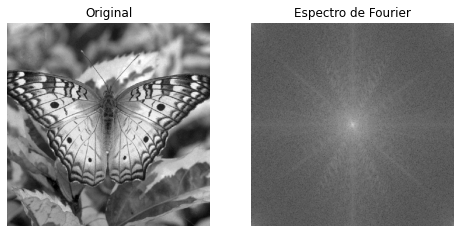

In [2]:
# Para mudar a imagem escolhida, basta trocar a variável img_name por outra imagem presente na pasta in
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

# Aplica transformada rápida d Fourier
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)
# Para visualizar o espectro de Fourier tomamos o logaritmo da magnitude (valor absoluto).
# Somamos 1 ao valor para garantir que o logaritmo esteja definido.
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    # Fazemos com que os valores do espectro estejam no intervalo [0, 255].
    espectro = (255/max_pixel)*espectro

# Desfaz o shift e aplica a transformada inversa
fshift = np.fft.ifftshift(ft)
img = np.fft.ifft2(fshift)
img = np.real(img)

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Original")
axarr[0].axis('off')

axarr[1].imshow(espectro, cmap = 'gray')
axarr[1].set_title("Espectro de Fourier")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/espectro.png', espectro):
    print("Falha ao salvar a imagem")

## Filtro passa-baixa ideal

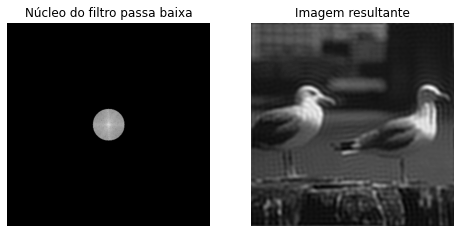

In [3]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Cria o círculo para filtrar a imagem
height = len(img)
width = len(img[0])
raio = 40
circle = np.zeros((height, width), np.uint8)
circle = cv2.circle(circle, (int(height/2), int(width/2)), raio, 1, -1)

low_pass = np.multiply(ft, circle)
nucleo = np.multiply(espectro, circle)

fshift = np.fft.ifftshift(low_pass)
low_pass = np.fft.ifft2(fshift)
low_pass = np.real(low_pass)

# Visualização das imagens
f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(nucleo, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(low_pass, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/nucleo_low.png', nucleo):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/low_ideal.png', low_pass):
    print("Falha ao salvar a imagem")

## Filtro passa-baixa de Butterworth

### Função dos filtros Butterworth: executar a célula seguinte antes de qualquer outra que utiliza esse filtro

In [4]:
# Parâmetros do filtro de Butterworth passa-baixa:
#   ft: função transformada pela fft da imagem
#   n: ordem
#   D0: frequência de corte
def butterworth_low(ft, n, D0):
    y, x = np.shape(ft)
    x_axis = np.arange(-np.floor(x/2), np.ceil(x/2))
    y_axis = np.arange(-np.floor(y/2), np.ceil(y/2))
    # Gera o plano para o cálculo de D
    A, B = np.meshgrid(x_axis, y_axis)
    D = np.sqrt(np.power(A, 2) + np.power(B, 2))
    H = 1/(1 + (D/D0)**(2*n))
    # Operação de convolução
    return A, B, H

def butterworth_high(ft, n, D0):
    y, x = np.shape(ft)
    x_axis = np.arange(-np.floor(x/2), np.ceil(x/2))
    y_axis = np.arange(-np.floor(y/2), np.ceil(y/2))
    A, B = np.meshgrid(x_axis, y_axis)
    # Somando 1 para evitar divisão por 0
    D = np.sqrt(np.power(A, 2) + np.power(B, 2) + 1)
    H = 1/(1 + (D0/D)**(2*n))
    return A, B, H

def butterworth_band(ft, n, D0, W):
    y, x = np.shape(ft)
    x_axis = np.arange(-np.floor(x/2), np.ceil(x/2))
    y_axis = np.arange(-np.floor(y/2), np.ceil(y/2))
    A, B = np.meshgrid(x_axis, y_axis)
    # Somando 1 para evitar divisão por 0
    D = np.sqrt(np.power(A, 2) + np.power(B, 2) + 1)
    H = 1 - 1/(1 + ((W*D)/(D**2 - D0**2))**(2*n))
    return A, B, H

### Ordem 2 e D0 = 40.

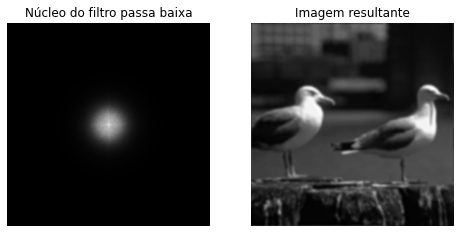

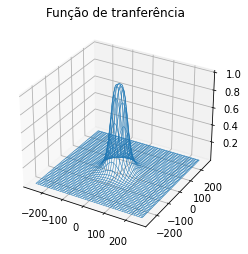

In [5]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
A, B, H = butterworth_low(ft, 2, 40)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Visualização das imagens
f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_low.png')
plt.show()

if not cv2.imwrite('out/low_butter2.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_low_butter2.png', H * espectro):
    print("Falha ao salvar a imagem")


### Ordem 10 e D0 = 40.

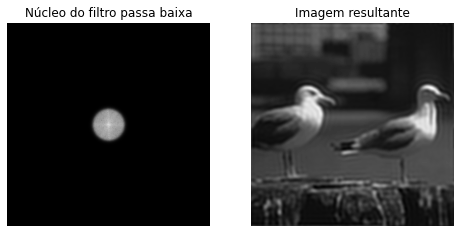

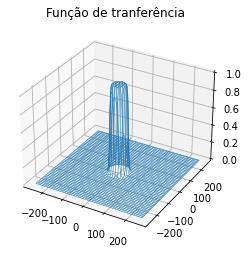

In [6]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

A, B, H = butterworth_low(ft, 10, 40)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_low.png')
plt.show()

if not cv2.imwrite('out/low_butter10.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_low_butter10.png', H * espectro):
    print("Falha ao salvar a imagem")


### Ordem 2 e D0 = 20.

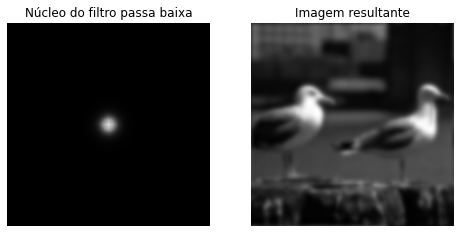

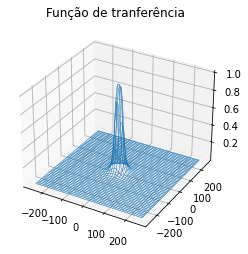

In [7]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

A, B, H = butterworth_low(ft, 2, 20)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Visualização das imagens
f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_low.png')
plt.show()

if not cv2.imwrite('out/low_butter20.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_low_butter20.png', H * espectro):
    print("Falha ao salvar a imagem")


## Filtro passa-alta de Butterworth

### Ordem 2 e D0 = 40

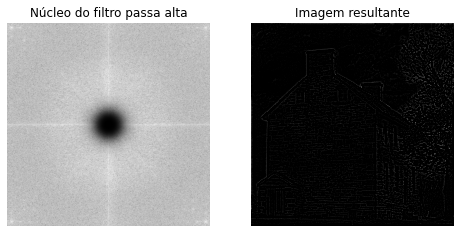

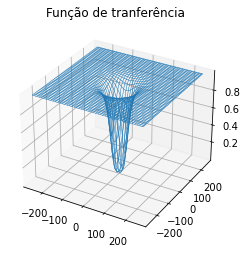

In [8]:
img_name = 'house.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
n = 2
D0 = 40
A, B, H = butterworth_high(ft, 2, D0)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa alta")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray', vmin=0, vmax=255)
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_high.png')
plt.show()

if not cv2.imwrite('out/high_butter40.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_high_butter40.png', H * espectro):
    print("Falha ao salvar a imagem")

### Ordem 2 e D0 = 20

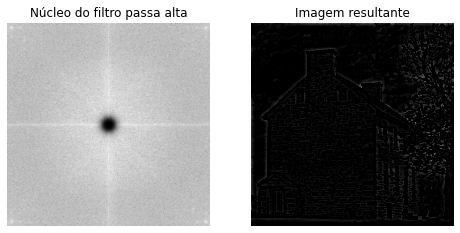

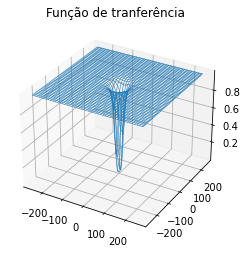

In [9]:
img_name = 'house.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
n = 2
D0 = 20
A, B, H = butterworth_high(ft, n, D0)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa alta")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray', vmin=0, vmax=255)
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_high.png')
plt.show()

if not cv2.imwrite('out/high_butter20.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_high_butter20.png', H * espectro):
    print("Falha ao salvar a imagem")

## Filtro passa-faixa de Butterworth

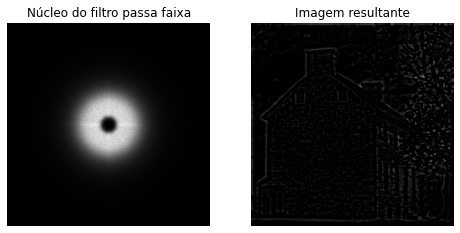

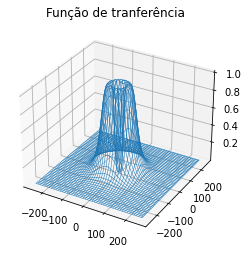

In [10]:
img_name = 'house.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
#   W: largura da banda
n = 2
D0 = 40
W = 60
A, B, H = butterworth_band(ft, n, D0, W)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa faixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray', vmin=0, vmax=255)
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
ax.set_title("Função de tranferência")
plt.savefig('out/transfer_band.png')
plt.show()

if not cv2.imwrite('out/band_butter.png', butterworth):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/nucleo_band_butter.png', H * espectro):
    print("Falha ao salvar a imagem")

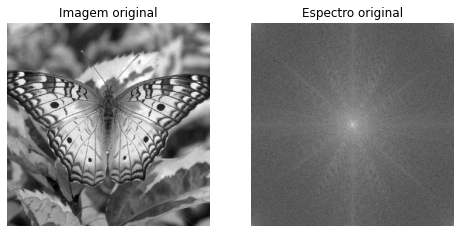

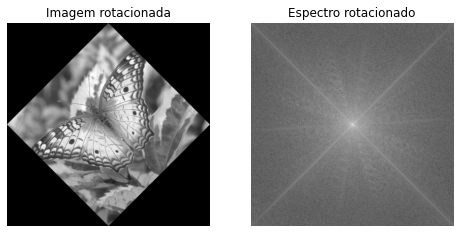

In [11]:
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Calcula o espectro da imagem original
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Rotaciona a imagem e reajusta seu tamanho para não ocorrer cortes
img_rot = transform.rotate(img, 45, resize=True)
# Reajusta a escala dos pixels
img_rot = 255/np.max(img_rot) * img_rot

ft_rot = np.fft.fft2(img_rot)
ft_rot = np.fft.fftshift(ft_rot)

# Calcula o espectro da imagem rotacionada
espectro_rot = np.log(np.abs(ft_rot) + 1)
if max_pixel > 0:
    espectro_rot = (255/max_pixel)*espectro_rot

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Imagem original")
axarr[0].axis('off')

axarr[1].imshow(espectro, cmap = 'gray')
axarr[1].set_title("Espectro original")
axarr[1].axis('off')
plt.show()

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img_rot, cmap = 'gray')
axarr[0].set_title("Imagem rotacionada")
axarr[0].axis('off')

axarr[1].imshow(espectro_rot, cmap = 'gray')
axarr[1].set_title("Espectro rotacionado")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/rotated.png', img_rot):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/rotated_spec.png', espectro_rot):
    print("Falha ao salvar a imagem")

### 10% dos maiores valores

Tempo para transformada e compressão: 0.061


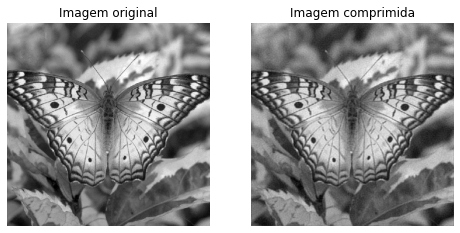

In [12]:
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

start = time.time()
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# O código de compressão de imagem a seguir foi baseado em [1]
# Ordenamos os coeficientes da transformada de modo a escolher um threshold 
# que delimita uma certa porcentagem dos maiores valores 
coef = np.sort(np.abs(np.reshape(ft,-1)))
keep = 0.1
threshold = coef[int(np.floor((1-keep)*len(coef)))]
ind = np.abs(ft) > threshold
compressed = ft * ind

# Desfaz o shift e aplica a transformada inversa
compressed = np.fft.ifftshift(compressed)
compressed = np.fft.ifft2(compressed)
compressed = np.real(compressed)

end = time.time()
print("Tempo para transformada e compressão: %.3f" %(end - start))

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Imagem original")
axarr[0].axis('off')

axarr[1].imshow(compressed, cmap = 'gray')
axarr[1].set_title("Imagem comprimida")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/compressed10.png', compressed):
    print("Falha ao salvar a imagem")

\[1\] BRUNTON,S.L;KUTZ, J.N. Sparcity and Compressed Sensing. _Data-Driven Science and Engineering: Machine Learning, Dynamical Systems and Control_. \[S.l.: s.n.\]. p.98.

### 1% dos maiores valores

Tempo para transformada e compressão: 0.058


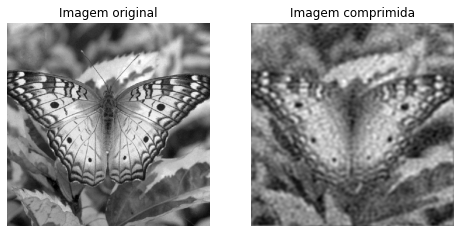

In [13]:
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

start = time.time()
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

coef = np.sort(np.abs(np.reshape(ft,-1)))
keep = 0.01
threshold = coef[int(np.floor((1-keep)*len(coef)))]
ind = np.abs(ft) > threshold
compressed = ft * ind

# Desfaz o shift e aplica a transformada inversa
compressed = np.fft.ifftshift(compressed)
compressed = np.fft.ifft2(compressed)
compressed = np.real(compressed)

end = time.time()
print("Tempo para transformada e compressão: %.3f" %(end - start))

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Imagem original")
axarr[0].axis('off')

axarr[1].imshow(compressed, cmap = 'gray')
axarr[1].set_title("Imagem comprimida")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/compressed1.png', compressed):
    print("Falha ao salvar a imagem")

### Cálculo do tempo para filtrar a imagem no domínio da frequência

### Cálculo do tempo para filtrar a imagem no domínio espacial

Tempo para filtragem da imagem: 0.088


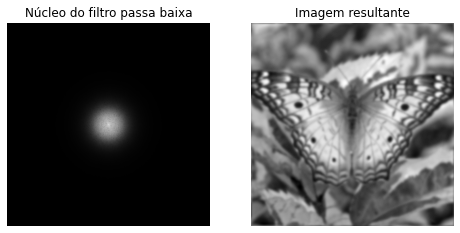

In [14]:
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

start = time.time()
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
A, B, H = butterworth_low(ft, 2, 40)
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

end = time.time()
print("Tempo para filtragem da imagem: %.3f" %(end - start))

# Cálculo do espectro de Fourier
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Visualização das imagens
f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

Tempo para filtragem da imagem com máscara 3x3: 0.025
Tempo para filtragem da imagem com máscara 7x7: 0.085
Tempo para filtragem da imagem com máscara 11x11: 0.180


(-0.5, 511.5, 511.5, -0.5)

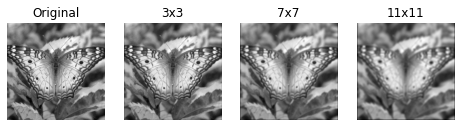

In [16]:
def filter(img, mask, m_name):
    start = time.time()
    pad_size = len(mask[0])//2
    mask_size = len(mask[0])
    # Faz o padding da imagem com zeros
    p_img = np.pad(img, pad_width=pad_size)
    row, col = np.shape(img)
    new_img = np.zeros((row, col), dtype=np.int32)

    # Divide a matriz da imagem em submatrizes com o tamanho da máscara (centradas em cada pixel da imagem original)
    windows = sk.util.shape.view_as_windows(p_img, (mask_size, mask_size))

    # Cálculo da convolução: multiplica a máscara pelas submatrizes elemento a elemento e depois os soma, gerando um novo pixel
    new_img = np.sum(np.multiply(mask, windows[:][:]), axis = (2, 3))

    new_img[new_img < 0] = 0
    new_img[new_img > 255] = 255
    new_img = new_img.astype(np.uint8)

    end = time.time()
    print("Tempo para filtragem da imagem com máscara " + m_name + ": %.3f" %(end - start))

    return new_img

img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

mask_3 = np.ones((3, 3)) * 1/9
mask_7 = np.ones((7, 7)) * 1/49
mask_11 = np.ones((11, 11)) * 1/121

f, axarr = plt.subplots(1, 4, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Original")
axarr[0].axis('off')

axarr[1].imshow(filter(img, mask_3, '3x3'), cmap = 'gray')
axarr[1].set_title("3x3")
axarr[1].axis('off')

axarr[2].imshow(filter(img, mask_7, '7x7'), cmap = 'gray')
axarr[2].set_title("7x7")
axarr[2].axis('off')

axarr[3].imshow(filter(img, mask_11, '11x11'), cmap = 'gray')
axarr[3].set_title("11x11")
axarr[3].axis('off')
